In [20]:
import pandas as pd 
import gc
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from keras import Sequential 
from keras.layers import Dense, InputLayer
from keras.utils.np_utils import to_categorical
import tensorflow as tf
from keras.models import load_model
tf.get_logger().setLevel('INFO')
tf.compat.v1.logging.set_verbosity('INFO')
import numpy as np
import pickle
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plot
import seaborn as sn

In [2]:
df = pd.read_csv('./dataset/sentences.csv', sep='\t', 
                            encoding='utf8', 
                            index_col=0,
                            names=['lang','text'])

In [3]:
LanguageList = ['eng','fra', 'spa','ita','deu']
ngramLength = 3
maxFeatures = 500
sentencePerLanguageForVocab = 1000
sentencePerLanguageForDataSet = 50000
validationSentences = 25000
testSentences = 25000

In [4]:
df = df[df['lang'].isin(LanguageList)]

In [5]:
model = load_model('./models/basic-model-2.model')
preprocessing_objects = pickle.load(open('./models/basic-model-2-preprocessing-objects.pkl','rb'))
word_vectorizer = preprocessing_objects['word_vectorizer']
langEncoder = preprocessing_objects['lang_encoder']
max_df = preprocessing_objects['max_df']
min_df = preprocessing_objects['min_df']
feature_names = word_vectorizer.get_feature_names()

2021-07-22 19:44:00.652093: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-07-22 19:44:02.090447: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-07-22 19:44:02.113816: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ninjabox): /proc/driver/nvidia/version does not exist
2021-07-22 19:44:02.115142: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
def data_generator(dataset, batch_size):
    noOfBatches = len(dataset)//batch_size
    batches = np.array_split(dataset,noOfBatches)
    i = 0
    while True:
        batch = batches[i]
        i += 1
        if i == noOfBatches:
            i = 0
        # getting x
        x = word_vectorizer.transform(batch['text'].to_list())
        xdf = pd.DataFrame(data=x.toarray(), columns=feature_names)
        xdf = (xdf - min_df)/(max_df - min_df)
        x_num = xdf.to_numpy()
    
        # getting y
        y = batch['lang'].to_list()
        y_enc = langEncoder.transform(y)
        y_num = to_categorical(y_enc, num_classes=len(LanguageList))
        yield x_num,y_num    

In [7]:
all_generator = data_generator(df, 100)
all_steps_per_epoch = len(df)//100
print(all_steps_per_epoch)

36601


In [8]:
def model_output_to_lang(outputs):
    labels = np.argmax(outputs,axis=1)
    return langEncoder.inverse_transform(labels)

In [9]:
def calculate_cf(my_model, allInput, allTarget):
    all_predictions = my_model.predict(allInput)
    test_target_lang=model_output_to_lang(allTarget)
    test_prediction_lang=model_output_to_lang(all_predictions)
    cf = confusion_matrix(test_target_lang,test_prediction_lang,labels=LanguageList)
    return cf

In [10]:
tf.get_logger().setLevel('ERROR')
tf.compat.v1.logging.set_verbosity('ERROR')
tf.autograph.set_verbosity(3)
all_input, all_target = next(all_generator)
cf = calculate_cf(model,all_input,all_target)

2021-07-22 19:44:09.121302: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-07-22 19:44:09.210065: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2699905000 Hz


In [11]:
for i in range(all_steps_per_epoch - 1):
    print('=',end='')
    curr_input,curr_target = next(all_generator)
    cf += calculate_cf(model,curr_input, curr_target)
    if i%100 == 0:
        print("{0} done".format(i))

=0 done
====================================================================================================100 done
====================================================================================================200 done
====================================================================================================300 done
====================================================================================================400 done
====================================================================================================500 done
====================================================================================================600 done
====================================================================================================700 done
====================================================================================================800 done
====================================================================================================900 done
===========

====================================================================================================14900 done
====================================================================================================15000 done
====================================================================================================15100 done
====================================================================================================15200 done
====================================================================================================15300 done
====================================================================================================15400 done
====================================================================================================15500 done
====================================================================================================15600 done
====================================================================================================15700 done
=

====================================================================================================29500 done
====================================================================================================29600 done
====================================================================================================29700 done
====================================================================================================29800 done
====================================================================================================29900 done
====================================================================================================30000 done
====================================================================================================30100 done
====================================================================================================30200 done
====================================================================================================30300 done
=

In [12]:
cf

array([[1490222,    2308,    3070,     848,     744],
       [    285,  465257,    1850,     509,     314],
       [    261,     569,  340915,    1867,      91],
       [    514,    2956,    8788,  779380,     131],
       [   1182,     305,     699,     326,  556757]])

In [32]:
print(np.sum(cf))
print(np.trace(cf))
print((np.sum(cf) - np.trace(cf))/np.sum(cf))
print(np.sum(cf) - np.trace(cf))

3660148
3632531
0.007545323303866401
27617


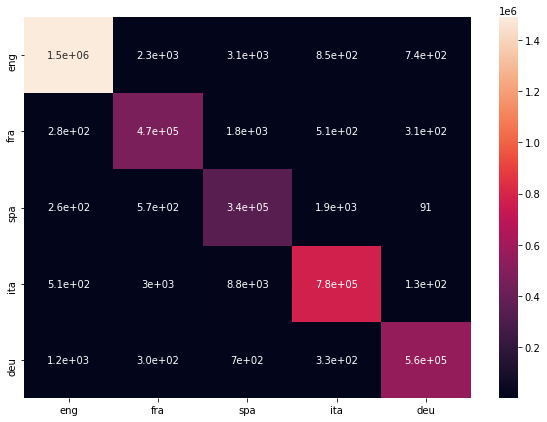

In [30]:
cf_df = pd.DataFrame(data=cf,columns=LanguageList,index=LanguageList)
plot.figure(figsize = (10,7))
sns_plot = sn.heatmap(cf_df, annot=True)

In [31]:
sns_plot.figure.savefig('./outputs/basic-model-2.png')